# Machine Learning model - Hierarchical Evaluation
- Category-Level Evaluation: Evaluate forecasts at the category level.
- Item-Level Evaluation: Evaluate forecasts at the item level, especially after adjusting the category-level forecasts.

- **Чому саме Hierarchical Evaluation машинного навчання?**

Цей підхід розділяє прогнозування на два рівні:

- Оцінка на рівні категорії: виявилення тенденцій та закономірностей спільних для груп товарів.
- Оцінка на рівні товару: оцінка прогнозів для окремих товарів, враховуючи та коригуючи результати прогнозування на рівні категорії. Це дозволяє отримати більш точні прогнози для кожного окремого продукту.

Такий підхід дозволяє ефективніше використовувати переваги різних моделей машинного навчання. Наприклад, для прогнозування на рівні категорії я можу використовувати моделі, що краще враховують загальні ринкові тенденції, тоді як для прогнозування на рівні товару – моделі, що враховують індивідуальні особливості кожного продукту.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)

## Define custom functions

In [ ]:
# Create lag features and rolling statistics for category data
def create_category_features(df):
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    for lag in [1, 2, 3, 7]:
        df[f'lag_{lag}'] = df['demand'].shift(lag)
    df['rolling_mean_7'] = df['demand'].shift(7).rolling(window=7).mean()
    df['rolling_std_7'] = df['demand'].shift(7).rolling(window=7).std()
    
    return df

In [ ]:
def plot_predictions_interactive(category_level_evaluation, category_models, category_data):
    category_dropdown = widgets.Dropdown(
        options=category_level_evaluation['category'].unique(),
        description='Select Category:',
    )

    def plot_predictions_and_mae(category):
        category_df = category_data[category_data['categ'] == category]

        if category_models[category] is None:
            print(f"No model available for category {category}.")
            return

        X = category_df[['price', 'day_of_week', 'month', 'week_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_7', 'rolling_mean_7', 'rolling_std_7']]
        y = category_df['demand']

        _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42) 

        predictions = category_models[category].predict(X_test)
        predictions = [round(x) for x in predictions]
        mae = mean_absolute_error(y_test, predictions)  

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(y_test.values, label='Actual', marker='o') 
        axes[0].plot(predictions, label='Predicted', marker='x')
        axes[0].set_title(f'Category {category} - Actual vs Predicted Demand')
        axes[0].set_xlabel('Time Steps')
        axes[0].set_ylabel('Demand')
        axes[0].legend()
        axes[0].grid(True)

        axes[1].bar([category], [mae]) 
        axes[1].set_title(f'Mean Absolute Error: {mae:.2f}')
        axes[1].set_ylabel('MAE')
        axes[1].set_ylim(0, category_level_evaluation['MAE'].max() * 1.1)

        plt.tight_layout()
        plt.show()

    interactive_plot = widgets.interactive_output(plot_predictions_and_mae, {'category': category_dropdown})
    display(category_dropdown, interactive_plot)


In [ ]:
def plot_forecast_interactive(forecasts): 

    category_dropdown = widgets.Dropdown(
        options=forecasts['categ'].unique(),
        description='Select Category:',
        disabled=False)
    
    def plot_forecast(category):
            category_forecast = forecasts[forecasts['categ'] == category]

            plt.figure(figsize=(10, 5))
            plt.plot(category_forecast['order_date'], category_forecast['category_forecast'], marker='o')

            for x, y in zip(category_forecast['order_date'], category_forecast['category_forecast']):
                label = "{:.2f}".format(y)
                plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

            plt.title(f'Forecast for {category}')
            plt.xlabel('Order Date')
            plt.ylabel('Category Forecast')
            plt.grid(True)
            plt.show()

    interactive_forecast = widgets.interactive_output(plot_forecast, {'category': category_dropdown})
    display(category_dropdown, interactive_forecast)


## Load data

In [ ]:
demand_data_pp = pd.read_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/demand_data_pp.csv')
demand_data_pp

## Prepare features for machine learning model

In [ ]:
# Sort data by date for each product
demand_data_pp = demand_data_pp.sort_values(by=['product_id', 'order_date'])
demand_data_pp['order_date'] = pd.to_datetime(demand_data_pp['order_date'])

# Aggregate data at the category level
category_data = demand_data_pp.groupby(['categ', 'order_date']).agg({
    'demand': 'sum',
    'price': 'mean'}).reset_index()
category_data.to_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/category_data.csv', index=False)
category_data.head()

In [ ]:
category_data = category_data.groupby('categ').apply(create_category_features).reset_index(drop=True)
category_data = category_data.dropna()
category_data

## CatBoostRegressor model Train

In [ ]:
category_data[category_data['categ']=='agro_industry_and_commerce'].shape[0]

In [ ]:
# define dictionaries to store results
category_models = {}
category_level_metrics = []

for category in category_data['categ'].unique():
    category_df = category_data[category_data['categ'] == category]

    # check if enough data points for the category
    if category_df.shape[0] < 10:  
        print(f"Skipping category {category} due to insufficient data.")
        continue 
        
    X = category_df[['price', 'day_of_week', 'month', 'week_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_7', 'rolling_mean_7', 'rolling_std_7']]
    y = category_df['demand']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    if np.var(y_train) < 1e-6:
        print(f"Low variance in category {category}. Using median demand for predictions.")
        model = None
        predictions = [np.median(y_train)] * len(y_test)
    else:
        model = CatBoostRegressor(random_state=42, loss_function='MAE', verbose=False)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        predictions = [round(x) for x in predictions]
    
    category_models[category] = model
    
    # evaluate
    mae = mean_absolute_error(y_test, predictions)
    category_level_metrics.append({'category': category, 'MAE': mae})
    
category_level_evaluation = pd.DataFrame(category_level_metrics)

In [ ]:
category_level_evaluation

## Evaluate the model

In [ ]:
plot_predictions_interactive(category_level_evaluation, category_models, category_data)

## Forecasting future demand 7+14 days

### forecasting category demand

In [ ]:
# Forecast future demand 7+14 days

forecast_start_date = demand_data_pp['order_date'].max() + pd.Timedelta(days=7)
forecast_end_date = forecast_start_date + pd.Timedelta(days=14)
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date)

# Create a DataFrame to store the forecasts
forecasts = pd.DataFrame()

# Iterate over each category and generate forecasts
for category in category_models.keys():
    #print(f"Processing category: {category}")
    category_df = category_data[category_data['categ'] == category]
    
    # Generate future features for the forecasting period
    future_data = pd.DataFrame({'order_date': forecast_dates})
    future_data['day_of_week'] = future_data['order_date'].dt.dayofweek
    future_data['month'] = future_data['order_date'].dt.month
    future_data['week_of_year'] = future_data['order_date'].dt.isocalendar().week
    future_data['price'] = category_df['price'].iloc[-1]
    
    future_data['lag_1'] = category_df['demand'].iloc[-1]
    future_data['lag_2'] = category_df['demand'].iloc[-2]
    future_data['lag_3'] = category_df['demand'].iloc[-3]
    future_data['lag_7'] = category_df['demand'].iloc[-7]
    future_data['rolling_mean_7'] = category_df['demand'].rolling(window=7).mean().iloc[-1]
    future_data['rolling_std_7'] = category_df['demand'].rolling(window=7).std().iloc[-1]
    
    # Predict category-level demand
    model = category_models.get(category)
    if model is None:
        print(f"Model for category {category} not found!")
        continue
    
    category_forecast = model.predict(future_data[['price', 'day_of_week', 'month', 'week_of_year', 
                                                   'lag_1', 'lag_2', 'lag_3', 'lag_7', 'rolling_mean_7', 'rolling_std_7']])
    
    future_data['category_forecast'] = category_forecast
    future_data['categ'] = category
    forecasts = pd.concat([forecasts, future_data], ignore_index=True)

forecasts['category_forecast'] = forecasts['category_forecast'].apply(lambda x: max(x, 0)).round(0)
forecasts[['order_date', 'category_forecast', 'categ']]

In [ ]:
plot_forecast_interactive(forecasts)

### forecasting items demand

In [ ]:
item_forecasts = pd.DataFrame()

for product_id in demand_data_pp['product_id'].unique():
    item_df = demand_data_pp[demand_data_pp['product_id'] == product_id].copy()
    category = item_df['categ'].iloc[0]
    category_demand_sum = category_data[category_data['categ'] == category]['demand'].sum()
    
    # Check if category_demand_sum is zero
    if category_demand_sum == 0:
        print(f"Skipping item {product_id} due to zero demand and allocating 0 by default.")
        category_forecast_df = forecasts[forecasts['categ'] == category].copy()
        category_forecast_df['item_forecast'] = 0
        category_forecast_df['product_id'] = product_id
    else:
        # historical demand ratio for the item
        item_ratio = item_df['demand'].sum() / category_demand_sum
        
        # category-level forecasts
        category_forecast_df = forecasts[forecasts['categ'] == category].copy()
        
        # Adjust the category-level forecast based on the item's historical demand ratio
        category_forecast_df['item_forecast'] = category_forecast_df['category_forecast'] * item_ratio
        category_forecast_df['item_forecast'] = category_forecast_df['item_forecast'].round(0)
        category_forecast_df['product_id'] = product_id
    
    item_forecasts = pd.concat([item_forecasts, category_forecast_df], ignore_index=True)

item_forecasts = item_forecasts[['order_date', 'category_forecast', 'categ', 'item_forecast', 'product_id']]
item_forecasts

In [ ]:
forecast_one_plus = item_forecasts[item_forecasts['item_forecast'] >= 1]
forecast_one_plus[['order_date', 'category_forecast', 'categ', 'item_forecast', 'product_id']]

In [ ]:
# Plot the forecast for a specific item
specific_product_id = 'ec5b3c8bb77ad22278f6e9d719a83de3'
specific_item_forecast = item_forecasts[item_forecasts['product_id'] == specific_product_id]

plt.figure(figsize=(10, 6))
plt.plot(specific_item_forecast['order_date'], specific_item_forecast['item_forecast'], marker='o')
plt.title(f'Predicted Demand for Product ID {specific_product_id}')
plt.xlabel('Order Date')
plt.ylabel('Predicted Demand')
plt.grid(True)
plt.show()

# TIME SERIES MODEL

- **SARIMAX TIME SERIES MODEL**:

**Переваги:**

- Експертиза часових рядів: Явно моделює часову структуру даних попиту, включаючи сезонність, тренди та автокореляцію.
- Інтерпретованість: Параметри моделі мають чітку інтерпретацію, пов'язану з компонентами часових рядів, що полегшує розуміння того, як різні фактори впливають на попит.
- Надійність: Зрілий і широко використовуваний підхід з добре зрозумілими статистичними властивостями.

**Недоліки:**

- Припущення: Спирається на певні припущення щодо процесу генерації даних, які можуть не завжди бути вірними.
- Обмежена гнучкість: Може не враховувати складні нелінійні зв'язки так ефективно, як деякі моделі машинного навчання.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)

## define custom function for TimeSeries model

In [ ]:
# Function to fill missing dates and set demand to 0
def fill_missing_dates(df, dates, category):
    df.set_index('order_date', inplace=True)
    df = df.reindex(dates, fill_value=0)
    df['categ'] = category
    df['demand'] = df['demand'].fillna(0)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'order_date'}, inplace=True)
    return df

In [ ]:
# Function to forecast demand
def forecast_demand(data, category, future_dates, order=(1, 1, 1), seasonal_order=(1,1,1,60)):
    data['order_date'] = pd.to_datetime(data['order_date'])
    category_df = data[data['categ'] == category].set_index('order_date').asfreq('D')

    # Ensure 'demand' is numeric
    category_df['demand'] = pd.to_numeric(category_df['demand'], errors='coerce')
    category_df = category_df.dropna()

    if category_df.shape[0] < 10:
        print(f"Skipping category {category} due to insufficient data.")
        return None, None 
    if np.var(category_df['demand']) < 1e-6:
        print(f"Skipping category {category} due to low variance in demand.")
        return None, None
    
    train_size = int(len(category_df) * 0.8)
    train, test = category_df.iloc[:train_size], category_df.iloc[train_size:]

    model = SARIMAX(
        train['demand'],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    try:
        results = model.fit(maxiter=300, pgtol=1e-2, method='lbfgs', start_params=None, disp=False)
    except Exception as e:
        print(f"Error fitting SARIMAX model for category {category}: {e}")
        return None, None 

    try:
        test_predictions = results.predict(start=test.index[0], end=test.index[-1])
        test_predictions = [round(x) for x in test_predictions]
        test_mae = mean_absolute_error(test['demand'], test_predictions)
        forecast = results.get_forecast(steps=21)
        forecast_df = forecast.summary_frame()
        forecast_df['mean'] = forecast_df['mean'].apply(lambda x: max(x, 0))
        forecast_df['date'] = future_dates
        forecast_df['categ'] = category
        return forecast_df, test_mae
    except Exception as e:
        print(f"Error generating forecast for category {category}: {e}")
        return None, None

In [ ]:
def create_mae_widget(mae_df):
    def display_mae(category):
        mae_value = mae_df[mae_df['category'] == category]['MAE'].values[0]
        print(f'MAE for {category}: {mae_value}')

    category_dropdown = widgets.Dropdown(
        options=mae_df['category'].tolist(),
        description='Category:',
        disabled=False)

    interactive_mae = widgets.interactive(display_mae, category=category_dropdown)
    display(interactive_mae)

def create_forecast_widget(forecast_df):
    def display_forecast(category):
        filtered_df = forecast_df[forecast_df['categ'] == category]
        display(filtered_df)

    category_dropdown = widgets.Dropdown(
        options=forecast_df['categ'].unique().tolist(),
        description='Category:',
        disabled=False)

    interactive_forecast = widgets.interactive(display_forecast, category=category_dropdown)
    display(interactive_forecast)


## Load data

In [ ]:
demand_data = pd.read_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/demand_data_pp.csv')
print(demand_data.shape)
demand_data.head()

In [ ]:
# Sort data by date for each product
demand_data = demand_data.sort_values(by=['product_id', 'order_date'])
demand_data['order_date'] = pd.to_datetime(demand_data['order_date'])
category_data = demand_data.groupby(['categ', 'order_date']).agg({'demand': 'sum'}).reset_index()
category_data.to_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/category_data.csv', index=False)
category_data

In [ ]:
# lets sea the range of our dates
categories = category_data['categ'].unique()
all_dates = pd.date_range(start=category_data['order_date'].min(), end=category_data['order_date'].max())
all_dates

## Impute missing dates and values for each category

In [ ]:
filled_data = []

# Loop through each category and fill missing dates
for category in categories:
    category_df = category_data[category_data['categ'] == category].copy()
    filled_category_df = fill_missing_dates(category_df, all_dates, category)
    filled_data.append(filled_category_df)

# Combine all filled data into a single DataFrame
category_data_filled = pd.concat(filled_data)
category_data_filled

In [ ]:
# Define future dates for forecasting with a gap of 7 days
last_date = category_data['order_date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=21, freq='D')
future_dates

## Predict demand by SARIMAX model and evaluate the results

In [ ]:
# define the frequency of our data
seasonal_ord = (1, 1, 1, 30)

# dictionaries to store our results for each category
forecasts = {}
mae_list = []

# Loop through each category
for category in categories:
    try:
        forecast_result, test_mae = forecast_demand(category_data_filled, category, future_dates, seasonal_order=seasonal_ord)
        if forecast_result is not None:
            forecasts[category] = forecast_result
            mae_list.append({'category': category, 'MAE': test_mae})
    except Exception as e:
        print(f"Error for category {category}: {e}")

## evaluate (metric: MAE)

In [ ]:
# Combine forecasts into a single DataFrame with required columns
if forecasts:
    forecast_df = pd.concat(forecasts.values(), ignore_index=True)
    forecast_df = forecast_df[['date', 'mean', 'categ']]
    forecast_df.rename(columns={'mean': 'demand'}, inplace=True)
    forecast_df['demand'] = forecast_df['demand'].apply(lambda x: max(x, 0)).round(0)
    ahead_14_days_forecast = forecast_df.groupby('categ').tail(14)
    all_forecast = ahead_14_days_forecast.groupby('date').sum().reset_index()
    all_forecast['categ'] = 'all'
    ahead_14_days_forecast = pd.concat([ahead_14_days_forecast, all_forecast], ignore_index=True)
    print(ahead_14_days_forecast)
else:
    print("No valid forecasts generated.")


In [ ]:
mae_df = pd.DataFrame(mae_list)
mae_df['MAE'] = mae_df['MAE'].round(3)
mae_df, ahead_14_days_forecast

In [ ]:
# run and select the category to display the mae(mean absolute error) for each category
create_mae_widget(mae_df)

## Make future predictions - ahead 14 days with a gap of 7 days

In [ ]:
# run and select the category to display the forecast for each category
create_forecast_widget(ahead_14_days_forecast)

# Conclusion:

Machine Learning model with the hierarchical approach give more accurate results

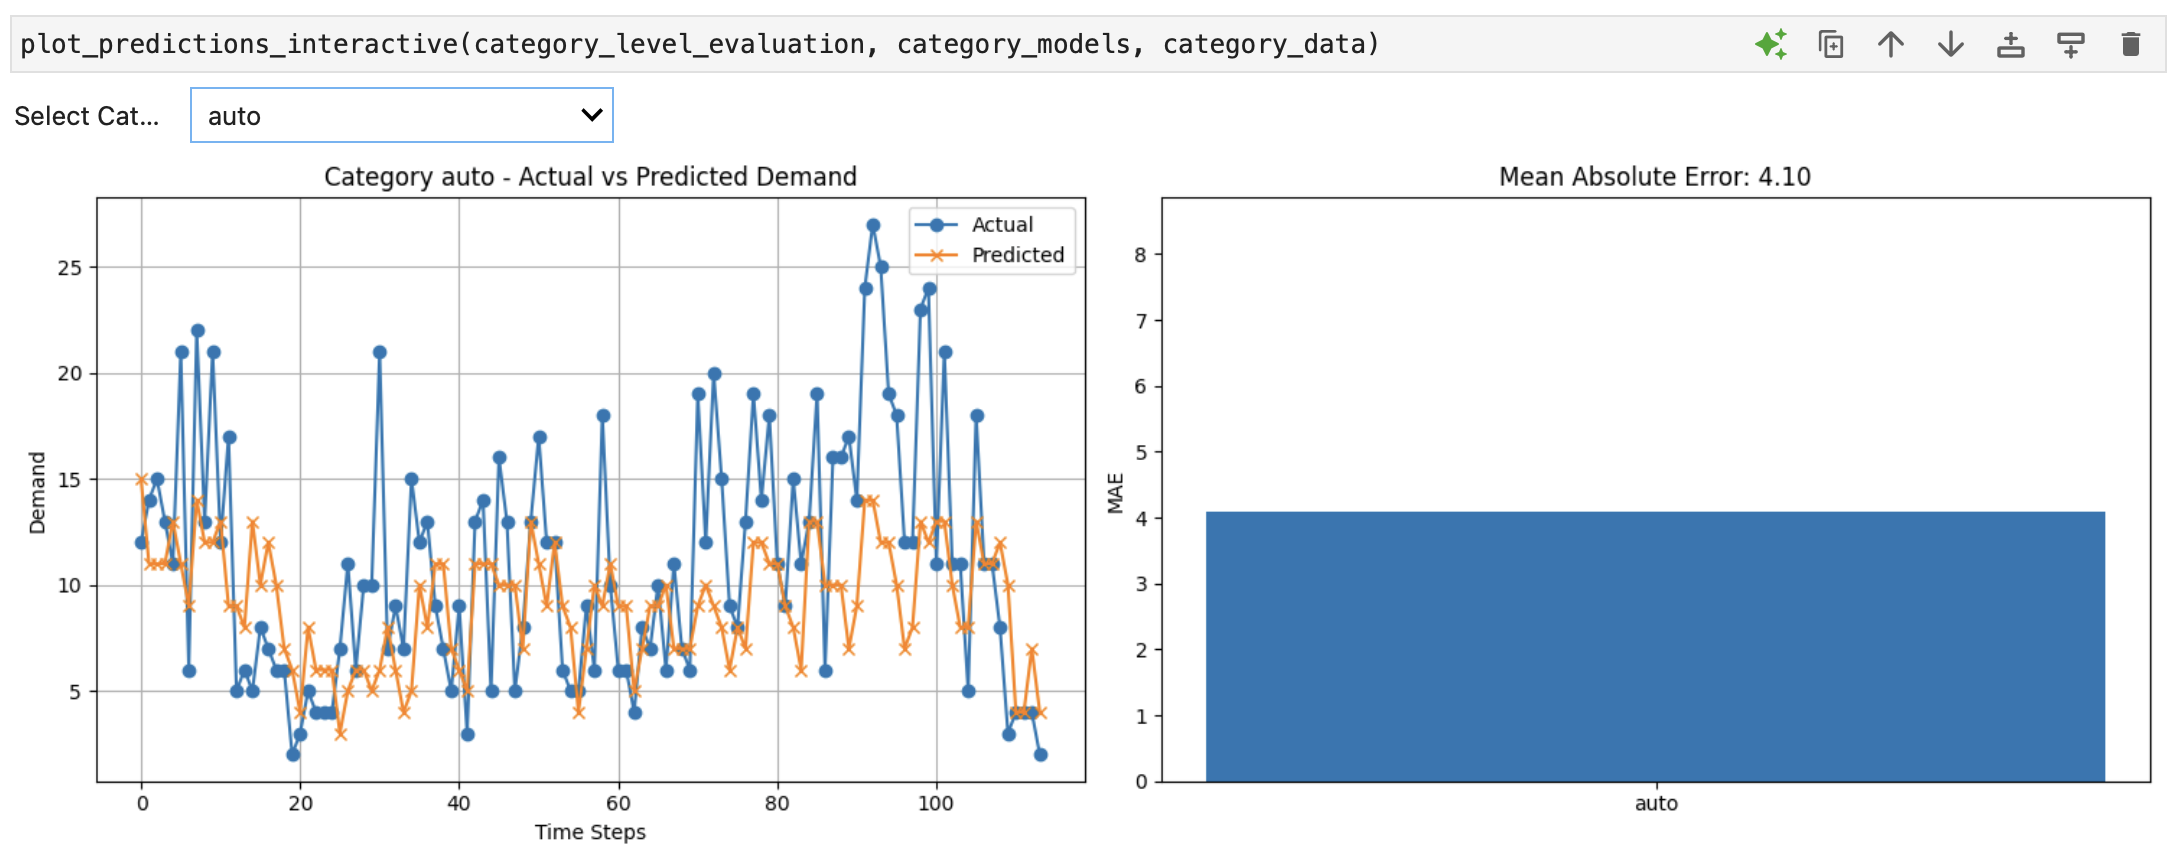

vs

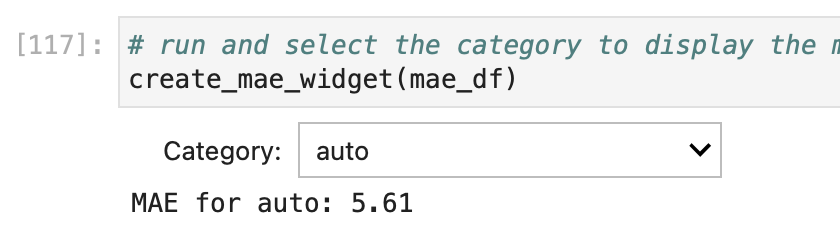

